# Tutorial: Averaging Neural Operator for solving Kuramoto Sivashinsky equation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial10/tutorial.ipynb)

In this tutorial we will build a Neural Operator using the
`AveragingNeuralOperator` model and the `SupervisedSolver`. At the end of the
tutorial you will be able to train a Neural Operator for learning
the operator of time dependent PDEs.


First of all, some useful imports. Note we use `scipy` for i/o operations.


In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab"
    # get the data
    !mkdir "data"
    !wget "https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial10/data/Data_KS.mat" -O "data/Data_KS.mat"
    !wget "https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial10/data/Data_KS2.mat" -O "data/Data_KS2.mat"

import torch
import matplotlib.pyplot as plt
import warnings

from scipy import io
from pina import Condition, Trainer, LabelTensor
from pina.model import AveragingNeuralOperator
from pina.solver import SupervisedSolver
from pina.problem.zoo import SupervisedProblem

warnings.filterwarnings("ignore")

## Data Generation

We will focus on solving a specific PDE, the **Kuramoto Sivashinsky** (KS) equation.
The KS PDE is a fourth-order nonlinear PDE with the following form:

$$
\frac{\partial u}{\partial t}(x,t) = -u(x,t)\frac{\partial u}{\partial x}(x,t)- \frac{\partial^{4}u}{\partial x^{4}}(x,t) - \frac{\partial^{2}u}{\partial x^{2}}(x,t).
$$

In the above $x\in \Omega=[0, 64]$ represents a spatial location, $t\in\mathbb{T}=[0,50]$ the time and $u(x, t)$ is the value of the function $u:\Omega \times\mathbb{T}\in\mathbb{R}$. We indicate with $\mathbb{U}$ a suitable space for $u$, i.e. we have that the solution $u\in\mathbb{U}$.


We impose Dirichlet boundary conditions on the derivative of $u$ on the border of the domain $\partial \Omega$
$$
\frac{\partial u}{\partial x}(x,t)=0 \quad \forall (x,t)\in \partial \Omega\times\mathbb{T}.
 $$

Initial conditions are sampled from a distribution over truncated Fourier series with random coefficients 
$\{A_k, \ell_k, \phi_k\}_k$ as
$$
    u(x,0) = \sum_{k=1}^N A_k \sin(2 \pi \ell_k x / L + \phi_k) \ ,
$$

where $A_k \in [-0.4, -0.3]$, $\ell_k = 2$, $\phi_k  = 2\pi \quad \forall k=1,\dots,N$. 


We have already generated some data for differenti initial conditions, and our objective will
be to build a Neural Operator that, given $u(x, t)$ will output $u(x, t+\delta)$, where
$\delta$ is a fixed time step. We will come back on the Neural Operator architecture, for now
we first need to import the data.

**Note:**
*The numerical integration is obtained by using pseudospectral method for spatial derivative discratization and
implicit Runge Kutta 5 for temporal dynamics.*


In [2]:
# load data
data = io.loadmat("data/Data_KS.mat")

# converting to label tensor
initial_cond_train = LabelTensor(
    torch.tensor(data["initial_cond_train"], dtype=torch.float),
    ["t", "x", "u0"],
)
initial_cond_test = LabelTensor(
    torch.tensor(data["initial_cond_test"], dtype=torch.float), ["t", "x", "u0"]
)
sol_train = LabelTensor(
    torch.tensor(data["sol_train"], dtype=torch.float), ["u"]
)
sol_test = LabelTensor(torch.tensor(data["sol_test"], dtype=torch.float), ["u"])

print("Data Loaded")
print(f" shape initial condition: {initial_cond_train.shape}")
print(f" shape solution: {sol_train.shape}")

Data Loaded
 shape initial condition: torch.Size([100, 12800, 3])
 shape solution: torch.Size([100, 12800, 1])


The data are saved in the form `B \times N \times D`, where `B` is the batch_size
(basically how many initial conditions we sample), `N` the number of points in the mesh
(which is the product of the discretization in `x` timese the one in `t`), and 
`D` the dimension of the problem (in this case we have three variables `[u, t, x]`).

We are now going to plot some trajectories!

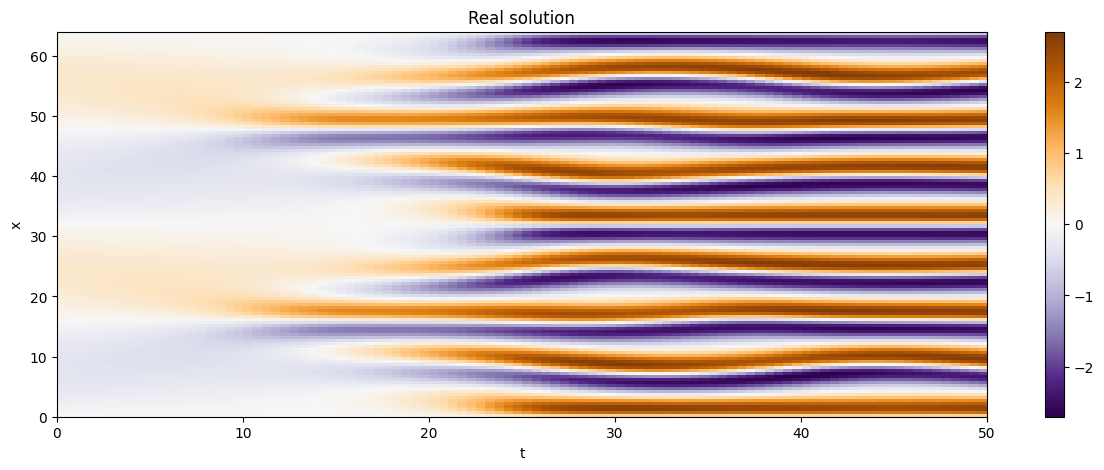

In [3]:
# helper function
def plot_trajectory(coords, real, no_sol=None):
    # find the x-t shapes
    dim_x = len(torch.unique(coords.extract("x")))
    dim_t = len(torch.unique(coords.extract("t")))
    # if we don't have the Neural Operator solution we simply plot the real one
    if no_sol is None:
        fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True, sharey=True)
        c = axs.imshow(
            real.reshape(dim_t, dim_x).T.detach(),
            extent=[0, 50, 0, 64],
            cmap="PuOr_r",
            aspect="auto",
        )
        axs.set_title("Real solution")
        fig.colorbar(c, ax=axs)
        axs.set_xlabel("t")
        axs.set_ylabel("x")
    # otherwise we plot the real one, the Neural Operator one, and their difference
    else:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
        axs[0].imshow(
            real.reshape(dim_t, dim_x).T.detach(),
            extent=[0, 50, 0, 64],
            cmap="PuOr_r",
            aspect="auto",
        )
        axs[0].set_title("Real solution")
        axs[1].imshow(
            no_sol.reshape(dim_t, dim_x).T.detach(),
            extent=[0, 50, 0, 64],
            cmap="PuOr_r",
            aspect="auto",
        )
        axs[1].set_title("NO solution")
        c = axs[2].imshow(
            (real - no_sol).abs().reshape(dim_t, dim_x).T.detach(),
            extent=[0, 50, 0, 64],
            cmap="PuOr_r",
            aspect="auto",
        )
        axs[2].set_title("Absolute difference")
        fig.colorbar(c, ax=axs.ravel().tolist())
        for ax in axs:
            ax.set_xlabel("t")
            ax.set_ylabel("x")
    plt.show()


# a sample trajectory (we use the sample 5, feel free to change)
sample_number = 20
plot_trajectory(
    coords=initial_cond_train[sample_number].extract(["x", "t"]),
    real=sol_train[sample_number].extract("u"),
)

As we can see, as the time progresses the solution becomes chaotic, which makes
it really hard to learn! We will now focus on building a Neural Operator using the
`SupervisedSolver` class to tackle the problem.

## Averaging Neural Operator

We will build a neural operator $\texttt{NO}$ which takes the solution at time $t=0$ for any $x\in\Omega$,
the time $(t)$ at which we want to compute the solution, and gives back the solution to the KS equation $u(x, t)$, mathematically:
$$
\texttt{NO}_\theta : \mathbb{U} \rightarrow  \mathbb{U},
$$
such that
$$
\texttt{NO}_\theta[u(t=0)](x, t) \rightarrow  u(x, t).
$$

There are many ways on approximating the following operator, e.g. by 2D [FNO](https://mathlab.github.io/PINA/_rst/models/fno.html) (for regular meshes),
a [DeepOnet](https://mathlab.github.io/PINA/_rst/models/deeponet.html), [Continuous Convolutional Neural Operator](https://mathlab.github.io/PINA/_rst/layers/convolution.html),
[MIONet](https://mathlab.github.io/PINA/_rst/models/mionet.html). 
In this tutorial we will use the *Averaging Neural Operator* presented in [*The Nonlocal Neural Operator: Universal Approximation*](https://arxiv.org/abs/2304.13221)
which is a [Kernel Neural Operator](https://mathlab.github.io/PINA/_rst/models/base_no.html) with integral kernel:

$$
K(v) = \sigma\left(Wv(x) + b + \frac{1}{|\Omega|}\int_\Omega v(y)dy\right)
$$

where:

*   $v(x)\in\mathbb{R}^{\rm{emb}}$ is the update for a function $v$ with $\mathbb{R}^{\rm{emb}}$ the embedding (hidden) size
*   $\sigma$ is a non-linear activation
*   $W\in\mathbb{R}^{\rm{emb}\times\rm{emb}}$ is a tunable matrix.
*   $b\in\mathbb{R}^{\rm{emb}}$ is a tunable bias.

If PINA many Kernel Neural Operators are already implemented, and the modular componets of the [Kernel Neural Operator](https://mathlab.github.io/PINA/_rst/models/base_no.html) class permits to create new ones by composing base kernel layers.

**Note:*** We will use the already built class* `AveragingNeuralOperator`, *as constructive excercise try to use the* [KernelNeuralOperator](https://mathlab.github.io/PINA/_rst/models/base_no.html) *class for building a kernel neural operator from scratch. You might employ the different layers that we have in pina, e.g.* [FeedForward](https://mathlab.github.io/PINA/_rst/models/fnn.html), *and* [AveragingNeuralOperator](https://mathlab.github.io/PINA/_rst/layers/avno_layer.html) *layers*.

In [4]:
class SIREN(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)


embedding_dimesion = 40  # hyperparameter embedding dimension
input_dimension = 3  # ['u', 'x', 't']
number_of_coordinates = 2  # ['x', 't']
lifting_net = torch.nn.Linear(input_dimension, embedding_dimesion)
projecting_net = torch.nn.Linear(embedding_dimesion + number_of_coordinates, 1)
model = AveragingNeuralOperator(
    lifting_net=lifting_net,
    projecting_net=projecting_net,
    coordinates_indices=["x", "t"],
    field_indices=["u0"],
    n_layers=4,
    func=SIREN,
)

Super easy! Notice that we use the `SIREN` activation function, more on [Implicit Neural Representations with Periodic Activation Functions](https://arxiv.org/abs/2006.09661).

## Solving the KS problem

We will now focus on solving the KS equation using the `SupervisedSolver` class
and the `AveragingNeuralOperator` model. As done in the [FNO tutorial](https://github.com/mathLab/PINA/blob/master/tutorials/tutorial5/tutorial.ipynb) we now create the Neural Operator problem class with `SupervisedProblem`.

In [5]:
# initialize problem
problem = SupervisedProblem(
    initial_cond_train,
    sol_train,
    input_variables=initial_cond_train.labels,
    output_variables=sol_train.labels,
)
# initialize solver
solver = SupervisedSolver(problem=problem, model=model)
# train, only CPU and avoid model summary at beginning of training (optional)
trainer = Trainer(
    solver=solver,
    max_epochs=40,
    accelerator="cpu",
    enable_model_summary=False,
    batch_size=5,  # we train on CPU and avoid model summary at beginning of training (optional)
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
)
trainer.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 39: 100%|██████████| 20/20 [00:01<00:00, 18.75it/s, v_num=9, data_loss_step=0.0809, train_loss_step=0.0809, data_loss_epoch=0.108, train_loss_epoch=0.108]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 20/20 [00:01<00:00, 18.70it/s, v_num=9, data_loss_step=0.0809, train_loss_step=0.0809, data_loss_epoch=0.108, train_loss_epoch=0.108]


We can now see some plots for the solutions

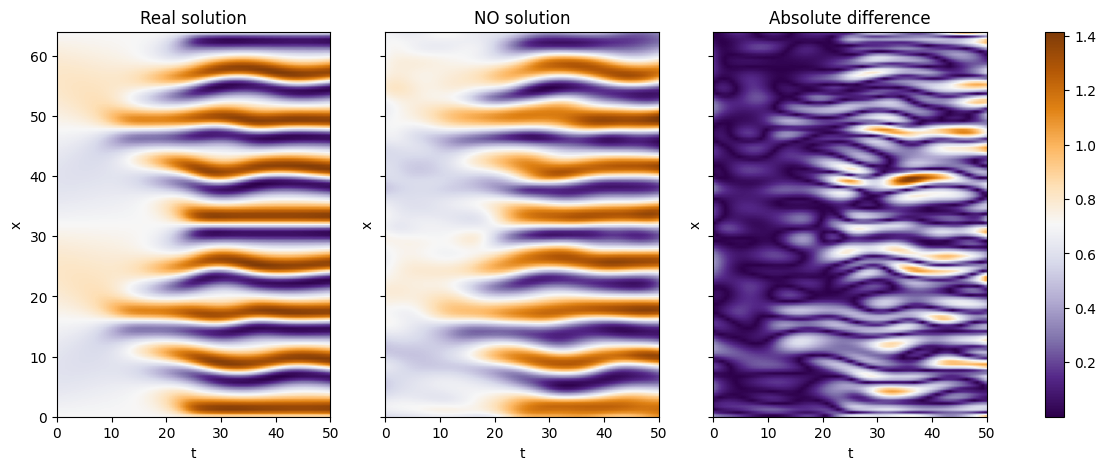

In [6]:
sample_number = 2
no_sol = solver(initial_cond_test)
plot_trajectory(
    coords=initial_cond_test[sample_number].extract(["x", "t"]),
    real=sol_test[sample_number].extract("u"),
    no_sol=no_sol[5],
)

As we can see we can obtain nice result considering the small training time and the difficulty of the problem!
Let's take a look at the training and testing error:

In [7]:
from pina.loss import PowerLoss

error_metric = PowerLoss(p=2)  # we use the MSE loss

with torch.no_grad():
    no_sol_train = solver(initial_cond_train)
    err_train = error_metric(
        sol_train.extract("u"), no_sol_train
    ).mean()  # we average the error over trajectories
    no_sol_test = solver(initial_cond_test)
    err_test = error_metric(
        sol_test.extract("u"), no_sol_test
    ).mean()  # we average the error over trajectories
    print(f"Training error: {float(err_train):.3f}")
    print(f"Testing error: {float(err_test):.3f}")

Training error: 0.107
Testing error: 0.097


As we can see the error is pretty small, which agrees with what we can see from the previous plots.

## What's next?

Now you know how to solve a time dependent neural operator problem in **PINA**! There are multiple directions you can go now:

1. Train the network for longer or with different layer sizes and assert the final accuracy

2. We left a more challenging dataset [Data_KS2.mat](dat/Data_KS2.mat) where $A_k \in [-0.5, 0.5]$, $\ell_k \in [1, 2, 3]$, $\phi_k \in [0, 2\pi]$ for longer training

3. Compare the performance between the different neural operators (you can even try to implement your favourite one!)